
# CIFAR-100 Image Classification Project

This notebook demonstrates a complete deep-learning pipeline for classifying images from the CIFAR-100 dataset using PyTorch.  The CIFAR-100 dataset contains 100 fine-grained classes grouped into 20 superclasses, with **600 images per class**—500 training and 100 test images—across 100 classes.  Our goal is to build a robust image classification model with reproducible training, perform exploratory data analysis (EDA), and evaluate the model thoroughly.  The notebook follows a modular, project-style structure so it’s easy to extend with different models or hyperparameter settings.


In [ ]:

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Use the first available GPU if present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility: set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Ensure deterministic behavior when possible
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Using device: cuda


In [ ]:

# Define transformation pipeline for training and validation/test sets
# We normalize using the CIFAR-100 mean and std values
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

train_dataset_full = datasets.CIFAR100(root='data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=val_test_transforms)

val_ratio = 0.1
num_train = int(len(train_dataset_full) * (1 - val_ratio))
num_val = len(train_dataset_full) - num_train
train_dataset, val_dataset = random_split(train_dataset_full, [num_train, num_val], generator=torch.Generator().manual_seed(seed))

val_dataset.dataset.transform = val_test_transforms

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

batch_size = 128
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


100%|██████████| 169M/169M [00:03<00:00, 42.9MB/s]


Train set size: 45000
Validation set size: 5000
Test set size: 10000



## 1. Exploratory Data Analysis

Before training a model it’s helpful to understand the distribution and structure of the data.  Below we compute statistics about the dataset, inspect the class distribution, and visualize some images.  We also use PCA and t-SNE to project high-dimensional image data to two dimensions for visualization.


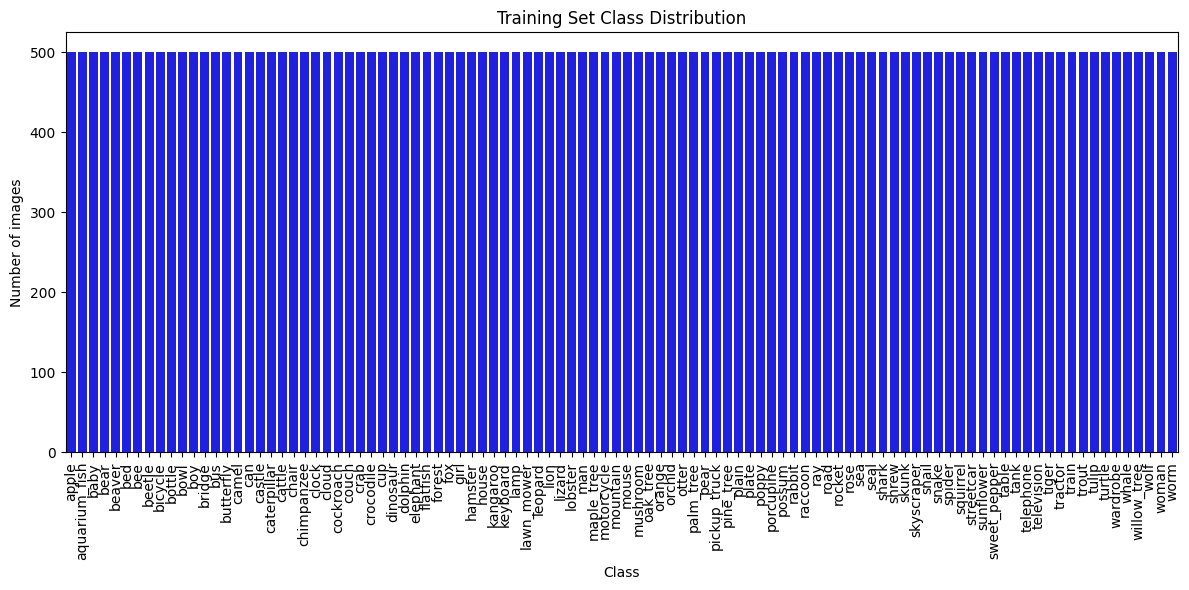

Number of classes: 100
Images per class (train): mean=500.0


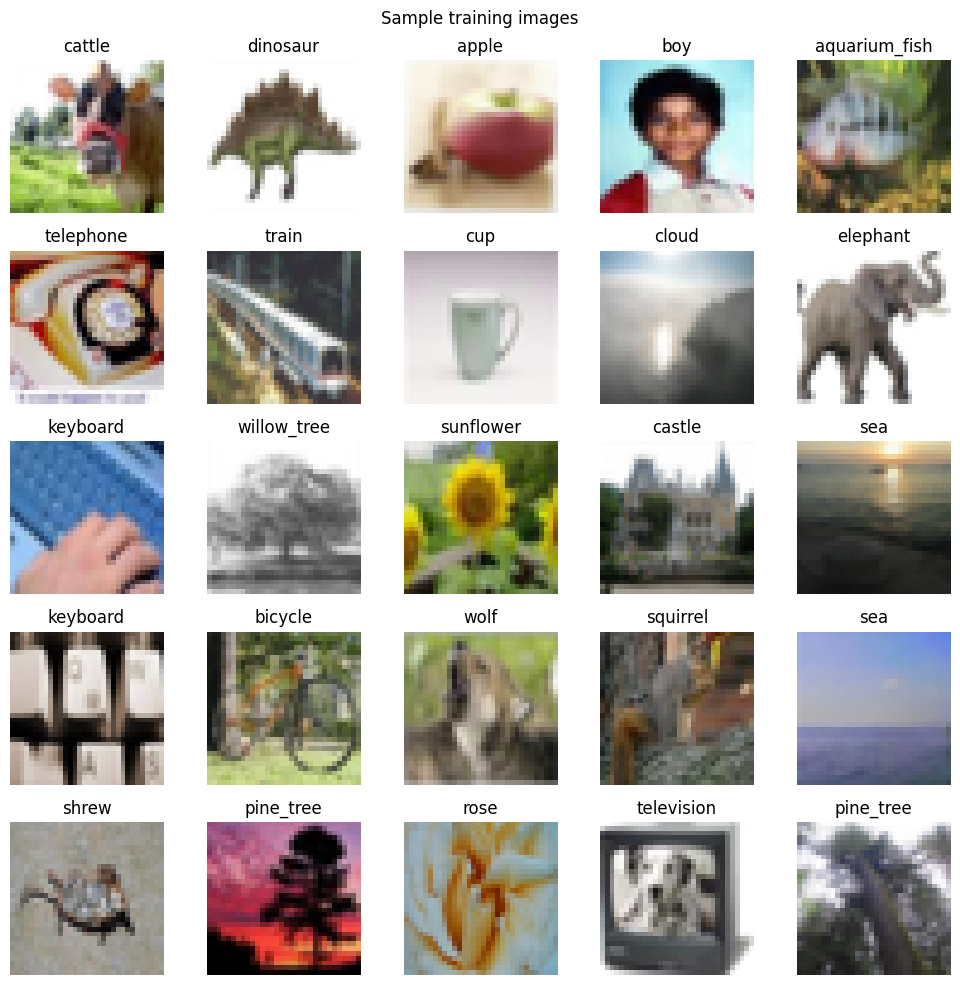

In [ ]:

# Compute basic dataset information
num_classes = len(train_dataset_full.classes)
class_names = train_dataset_full.classes

# Class distribution in the training set
class_counts = {class_name: 0 for class_name in class_names}
for _, label in train_dataset_full:
    class_counts[class_names[label]] += 1

# Display class distribution
plt.figure(figsize=(12, 6))
plt.title("Training Set Class Distribution")
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), color='blue')
plt.xticks(rotation=90)
plt.ylabel('Number of images')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

print(f"Number of classes: {num_classes}")
print(f"Images per class (train): mean={np.mean(list(class_counts.values()))}")

# Show sample images from a few classes
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Sample training images')
for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset_full[i]
    # Unnormalize for display
    img_show = img * torch.tensor(cifar100_std).view(3,1,1) + torch.tensor(cifar100_mean).view(3,1,1)
    img_show = img_show.permute(1, 2, 0).numpy()
    ax.imshow(np.clip(img_show, 0, 1))
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


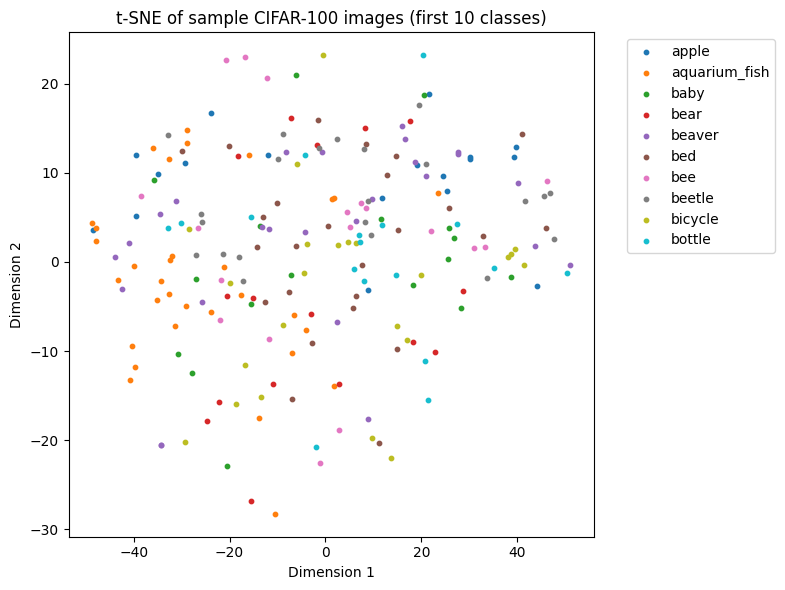

In [ ]:

# Visualize using PCA followed by t-SNE on a subset of the data
sample_size = 2000  # number of images to sample for visualization
indices = np.random.choice(len(train_dataset_full), size=sample_size, replace=False)
images = []
labels = []
for idx in indices:
    img, lbl = train_dataset_full[idx]
    img = img.view(-1)  # flatten
    images.append(img.numpy())
    labels.append(lbl)
images = np.stack(images)
labels = np.array(labels)

# Reduce dimensionality with PCA to 50 components to speed up t-SNE
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images)

# t-SNE to 2D
tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_iter=1000)
images_tsne = tsne.fit_transform(images_pca)

# Plot t-SNE with a few selected classes to avoid over-plotting
selected_classes = list(range(10))  # visualize first 10 classes
plt.figure(figsize=(8,6))
for cls in selected_classes:
    cls_mask = labels == cls
    plt.scatter(images_tsne[cls_mask, 0], images_tsne[cls_mask, 1], label=class_names[cls], s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of sample CIFAR-100 images (first 10 classes)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()



## 2. Model Selection

Convolutional neural networks (CNNs) are the de-facto standard for image classification tasks because they learn translation-invariant filters that capture spatial patterns.  To keep the code modular and extensible, we encapsulate the model in a class and group hyperparameters in a dictionary.  You can swap the network architecture or adjust the hyperparameters in a single location.


In [ ]:

class CNN(nn.Module):
    #convolutional neural network for CIFAR-100 classification
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Hyperparameters in one place
hyperparams = {
    'num_epochs': 60,
    'learning_rate': 0.001,
    'batch_size': batch_size,
    'weight_decay': 1e-4
}

# Initialize model, loss function and optimizer
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])


Epoch 1/60 - Train loss: 3.7834, Train acc: 0.1183, Val loss: 3.2271, Val acc: 0.2058
Epoch 2/60 - Train loss: 3.0105, Train acc: 0.2439, Val loss: 2.5927, Val acc: 0.3278
Epoch 3/60 - Train loss: 2.5375, Train acc: 0.3342, Val loss: 2.3608, Val acc: 0.3746
Epoch 4/60 - Train loss: 2.2478, Train acc: 0.3939, Val loss: 2.1249, Val acc: 0.4206
Epoch 5/60 - Train loss: 2.0205, Train acc: 0.4420, Val loss: 2.1452, Val acc: 0.4352
Epoch 6/60 - Train loss: 1.8530, Train acc: 0.4788, Val loss: 1.9232, Val acc: 0.4768
Epoch 7/60 - Train loss: 1.7169, Train acc: 0.5135, Val loss: 1.9488, Val acc: 0.4726
Epoch 8/60 - Train loss: 1.5764, Train acc: 0.5468, Val loss: 1.8195, Val acc: 0.4994
Epoch 9/60 - Train loss: 1.4501, Train acc: 0.5742, Val loss: 1.7960, Val acc: 0.5004
Epoch 10/60 - Train loss: 1.3280, Train acc: 0.6068, Val loss: 1.7928, Val acc: 0.5094
Epoch 11/60 - Train loss: 1.2349, Train acc: 0.6306, Val loss: 1.9447, Val acc: 0.4952
Epoch 12/60 - Train loss: 1.1279, Train acc: 0.6568,

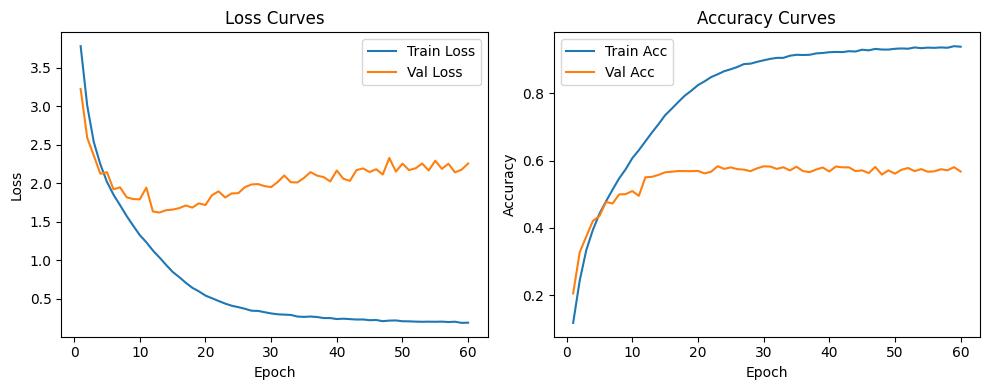

In [ ]:

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)

# Training loop
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(hyperparams['num_epochs']):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{hyperparams['num_epochs']} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")


PATH = f"/content/CNN_weights_Epochs_{hyperparams['num_epochs']}_.pth"

# Save the model's state_dict
torch.save(model.state_dict(), PATH)
print(f"Model state_dict saved to {PATH}")


# Plot training and validation curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, hyperparams['num_epochs']+1), train_losses, label='Train Loss')
plt.plot(range(1, hyperparams['num_epochs']+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, hyperparams['num_epochs']+1), train_accuracies, label='Train Acc')
plt.plot(range(1, hyperparams['num_epochs']+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()


Test accuracy: 0.5721
               precision    recall  f1-score   support

        apple       0.70      0.87      0.78       100
aquarium_fish       0.68      0.67      0.68       100
         baby       0.49      0.43      0.46       100
         bear       0.51      0.31      0.39       100
       beaver       0.41      0.37      0.39       100
          bed       0.52      0.69      0.59       100
          bee       0.63      0.56      0.59       100
       beetle       0.73      0.57      0.64       100
      bicycle       0.70      0.72      0.71       100
       bottle       0.62      0.79      0.70       100
         bowl       0.33      0.49      0.40       100
          boy       0.49      0.31      0.38       100
       bridge       0.67      0.66      0.66       100
          bus       0.52      0.59      0.55       100
    butterfly       0.53      0.47      0.50       100
        camel       0.38      0.67      0.48       100
          can       0.55      0.59      0.

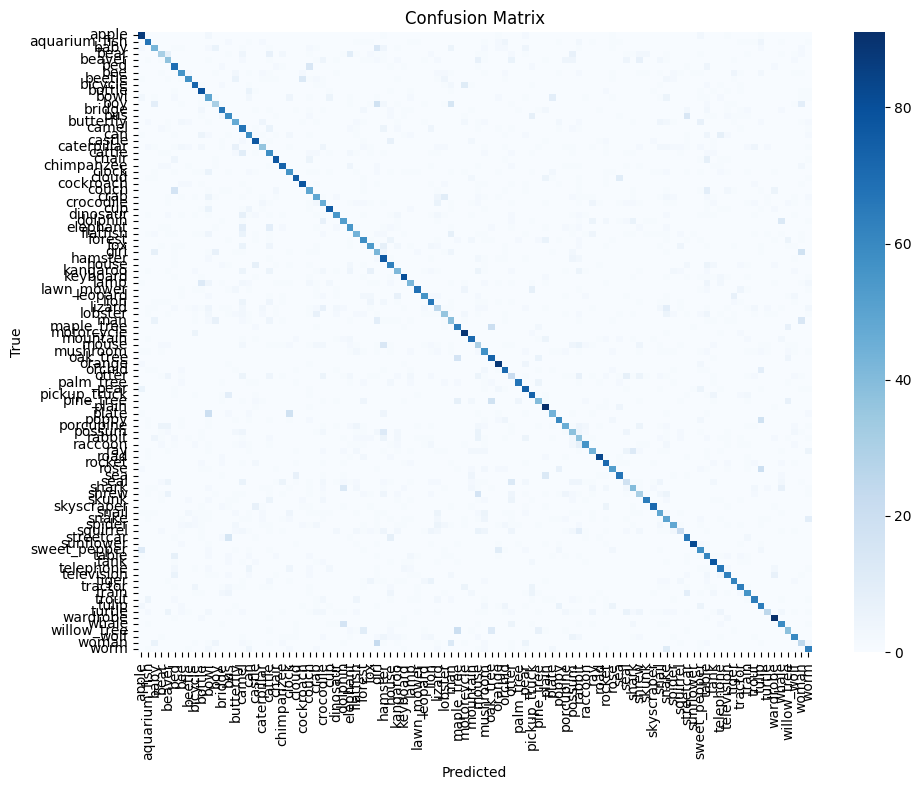

In [ ]:

# Evaluate on the test set
_, test_acc, targets, preds = evaluate(model, test_loader, criterion)
print(f"Test accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
report = classification_report(targets, preds, target_names=class_names)
print(report)

# Confusion matrix
conf_mat = confusion_matrix(targets, preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



## 3. Model Interpretability

Understanding why a model predicts a particular class is important for trust and debugging.  We use a simple saliency map approach: the gradient of the predicted class score with respect to the input pixels highlights which pixels most influence the decision.  Captum and PyTorch make it straightforward to compute such maps.


In [ ]:
!pip install captum

In [ ]:

from captum.attr import Saliency

# Function to generate saliency maps
saliency = Saliency(model)
model.eval()

# Select a handful of test images
num_interpret = 10
samples = []
sample_labels = []
for i in range(num_interpret):
    img, label = test_dataset[i]
    samples.append(img)
    sample_labels.append(label)

inputs = torch.stack(samples).to(device)
inputs.requires_grad = True

# Forward pass and compute saliency for predicted class
outputs = model(inputs)
preds = outputs.argmax(dim=1)

# Compute saliency maps
saliency_maps = saliency.attribute(inputs, target=preds)

# Visualize saliency maps
fig, axes = plt.subplots(num_interpret, 2, figsize=(6, 3*num_interpret))
for i in range(num_interpret):
    # Unnormalize original image for visualization
    img = inputs[i].cpu() * torch.tensor(cifar100_std).view(3,1,1) + torch.tensor(cifar100_mean).view(3,1,1)
    img = img.permute(1,2,0).detach().numpy()
    sal_map = saliency_maps[i].cpu().abs().mean(dim=0).numpy()
    # Normalize saliency map for display
    sal_map = (sal_map - sal_map.min()) / (sal_map.max() - sal_map.min() + 1e-8)
    axes[i,0].imshow(np.clip(img, 0, 1))
    axes[i,0].axis('off')
    axes[i,0].set_title(f"True: {class_names[sample_labels[i]]}, Pred: {class_names[preds[i]]}")
    axes[i,1].imshow(sal_map, cmap='hot')
    axes[i,1].axis('off')
    axes[i,1].set_title('Saliency Map')
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined


## 4. Conclusion

This notebook presented a complete CIFAR-100 classification pipeline using PyTorch.  We explored the data distribution, visualized high-dimensional data using t-SNE, built a convolutional neural network, trained it with reproducibility controls, evaluated its performance with detailed metrics and a confusion matrix, and visualized saliency maps to interpret the model’s decisions.  The modular structure allows you to swap architectures, tweak hyperparameters, or extend analysis with minimal changes.


Research Exploration : We explored clip models

In [ ]:
# ============================================================
# CIFAR-100 Classification with OpenAI CLIP
# ============================================================
# OpenAI CLIP for CIFAR-100 performance with three approaches:
# 1. Zero-shot classification (no training)
# 2. Linear probe (freeze CLIP, train classifier)
# 3. Fine-tuning CLIP (train everything)

!pip uninstall -y open_clip_torch
!pip install git+https://github.com/openai/CLIP.git

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

import sys
if 'clip' in sys.modules:
    del sys.modules['clip']
import clip


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


model_name = "ViT-B/32"
clip_model, preprocess = clip.load(model_name, device=device)
print(f"Loaded CLIP model: {model_name}")


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711))
])
val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711))
])
train_dataset_full = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=val_test_transform)
train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset.dataset.transform = val_test_transform
class_names = train_dataset_full.classes
num_classes = len(class_names)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print("\n==============================\nZero-Shot Classification\n==============================")
text_prompts = [f"a photo of a {class_name}" for class_name in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
def zero_shot_predict(model, loader, text_features):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Zero-shot inference"):
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            _, predicted = similarity.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
    return np.array(all_targets), np.array(all_preds)
targets, preds = zero_shot_predict(clip_model, test_loader, text_features)
zero_shot_accuracy = (targets == preds).mean()
print(f"Zero-shot Test Accuracy: {zero_shot_accuracy*100:.2f}%")


class CLIPLinearProbe(nn.Module):
    def __init__(self, clip_model, num_classes, feature_dim=512):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Linear(feature_dim, num_classes)
        for param in self.clip_model.parameters():
            param.requires_grad = False
    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features.float())
        return logits
linear_probe = CLIPLinearProbe(clip_model, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_probe.classifier.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in tqdm(loader, desc="Training"):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    for images, targets in tqdm(loader, desc="Evaluating"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []
print("\nTraining Linear Probe...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(linear_probe, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(linear_probe, val_loader, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
test_loss, test_acc, test_targets, test_preds = evaluate(linear_probe, test_loader, criterion)
print(f"\nLinear Probe Test Accuracy: {test_acc*100:.2f}%")


class CLIPFineTune(nn.Module):
    def __init__(self, clip_model, num_classes, feature_dim=512):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(feature_dim, num_classes)
        )
    def forward(self, images):
        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features.float())
        return logits
finetune_model = CLIPFineTune(clip_model, num_classes).to(device)
optimizer_ft = optim.AdamW([
    {'params': finetune_model.clip_model.parameters(), 'lr': 1e-6},
    {'params': finetune_model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=0.01)
scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=15)
num_epochs_ft = 15
train_losses_ft, train_accs_ft = [], []
val_losses_ft, val_accs_ft = [], []
print("\nFine-tuning CLIP...")
for epoch in range(num_epochs_ft):
    train_loss, train_acc = train_epoch(finetune_model, train_loader, optimizer_ft, criterion)
    val_loss, val_acc, _, _ = evaluate(finetune_model, val_loader, criterion)
    scheduler_ft.step()
    train_losses_ft.append(train_loss)
    train_accs_ft.append(train_acc)
    val_losses_ft.append(val_loss)
    val_accs_ft.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs_ft} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
ft_test_loss, ft_test_acc, ft_test_targets, ft_test_preds = evaluate(finetune_model, test_loader, criterion)
print(f"\nFine-tuned CLIP Test Accuracy: {ft_test_acc*100:.2f}%")


torch.save(linear_probe.state_dict(), 'clip_linear_probe.pth')
torch.save(finetune_model.state_dict(), 'clip_finetuned.pth')
print("\nModels saved successfully!")


print("\n==============================\nSummary Results\n==============================")
print(f"Zero-shot CLIP:        {zero_shot_accuracy*100:.2f}%")
print(f"Linear Probe:          {test_acc*100:.2f}%")
print(f"Fine-tuned CLIP:       {ft_test_acc*100:.2f}%")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vr11y310
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vr11y310
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Using device: cuda


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.3MiB/s]


Loaded CLIP model: ViT-B/32

Zero-Shot Classification


Zero-shot inference: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


Zero-shot Test Accuracy: 60.58%

Training Linear Probe...


Evaluating: 100%|██████████| 40/40 [00:11<00:00,  3.46it/s]


Epoch 1/20 - Train Loss: 4.2411, Train Acc: 0.4897, Val Loss: 3.8995, Val Acc: 0.6430


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


Epoch 2/20 - Train Loss: 3.6174, Train Acc: 0.6495, Val Loss: 3.3565, Val Acc: 0.6596


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s]


Epoch 3/20 - Train Loss: 3.1488, Train Acc: 0.6630, Val Loss: 2.9585, Val Acc: 0.6724


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s]


Epoch 4/20 - Train Loss: 2.8124, Train Acc: 0.6719, Val Loss: 2.6791, Val Acc: 0.6776


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


Epoch 5/20 - Train Loss: 2.5780, Train Acc: 0.6796, Val Loss: 2.4861, Val Acc: 0.6850


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s]


Epoch 6/20 - Train Loss: 2.4168, Train Acc: 0.6842, Val Loss: 2.3530, Val Acc: 0.6888


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.17it/s]


Epoch 7/20 - Train Loss: 2.3048, Train Acc: 0.6880, Val Loss: 2.2621, Val Acc: 0.6922


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.87it/s]


Epoch 8/20 - Train Loss: 2.2269, Train Acc: 0.6916, Val Loss: 2.1970, Val Acc: 0.6936


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Epoch 9/20 - Train Loss: 2.1718, Train Acc: 0.6941, Val Loss: 2.1507, Val Acc: 0.6932


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Epoch 10/20 - Train Loss: 2.1321, Train Acc: 0.6976, Val Loss: 2.1181, Val Acc: 0.6956


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Epoch 11/20 - Train Loss: 2.1032, Train Acc: 0.6995, Val Loss: 2.0937, Val Acc: 0.6972


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]


Epoch 12/20 - Train Loss: 2.0821, Train Acc: 0.6992, Val Loss: 2.0763, Val Acc: 0.6972


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]


Epoch 13/20 - Train Loss: 2.0666, Train Acc: 0.7013, Val Loss: 2.0635, Val Acc: 0.6976


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


Epoch 14/20 - Train Loss: 2.0553, Train Acc: 0.7022, Val Loss: 2.0542, Val Acc: 0.6984


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.20it/s]


Epoch 15/20 - Train Loss: 2.0470, Train Acc: 0.7032, Val Loss: 2.0479, Val Acc: 0.6986


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Epoch 16/20 - Train Loss: 2.0413, Train Acc: 0.7040, Val Loss: 2.0436, Val Acc: 0.6984


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s]


Epoch 17/20 - Train Loss: 2.0375, Train Acc: 0.7034, Val Loss: 2.0408, Val Acc: 0.6986


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.03it/s]


Epoch 18/20 - Train Loss: 2.0351, Train Acc: 0.7036, Val Loss: 2.0393, Val Acc: 0.6988


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s]


Epoch 19/20 - Train Loss: 2.0338, Train Acc: 0.7036, Val Loss: 2.0386, Val Acc: 0.6988


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


Epoch 20/20 - Train Loss: 2.0333, Train Acc: 0.7039, Val Loss: 2.0385, Val Acc: 0.6988


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.16it/s]



Linear Probe Test Accuracy: 68.99%

Fine-tuning CLIP...


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s]


Epoch 1/15 - Train Loss: 4.5698, Train Acc: 0.1090, Val Loss: 4.5330, Val Acc: 0.2816


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


Epoch 2/15 - Train Loss: 4.4972, Train Acc: 0.3955, Val Loss: 4.4620, Val Acc: 0.5332


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


Epoch 3/15 - Train Loss: 4.4275, Train Acc: 0.5484, Val Loss: 4.3941, Val Acc: 0.6186


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


Epoch 4/15 - Train Loss: 4.3612, Train Acc: 0.6084, Val Loss: 4.3305, Val Acc: 0.6410


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.85it/s]


Epoch 5/15 - Train Loss: 4.3003, Train Acc: 0.6341, Val Loss: 4.2726, Val Acc: 0.6538


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.95it/s]


Epoch 6/15 - Train Loss: 4.2454, Train Acc: 0.6422, Val Loss: 4.2211, Val Acc: 0.6594


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.12it/s]


Epoch 7/15 - Train Loss: 4.1968, Train Acc: 0.6502, Val Loss: 4.1764, Val Acc: 0.6626


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.17it/s]


Epoch 8/15 - Train Loss: 4.1556, Train Acc: 0.6537, Val Loss: 4.1389, Val Acc: 0.6618


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.10it/s]


Epoch 9/15 - Train Loss: 4.1219, Train Acc: 0.6547, Val Loss: 4.1088, Val Acc: 0.6634


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.09it/s]


Epoch 10/15 - Train Loss: 4.0951, Train Acc: 0.6566, Val Loss: 4.0856, Val Acc: 0.6654


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.31it/s]


Epoch 11/15 - Train Loss: 4.0750, Train Acc: 0.6577, Val Loss: 4.0689, Val Acc: 0.6656


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


Epoch 12/15 - Train Loss: 4.0610, Train Acc: 0.6574, Val Loss: 4.0579, Val Acc: 0.6656


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


Epoch 13/15 - Train Loss: 4.0522, Train Acc: 0.6566, Val Loss: 4.0515, Val Acc: 0.6660


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


Epoch 14/15 - Train Loss: 4.0475, Train Acc: 0.6588, Val Loss: 4.0486, Val Acc: 0.6660


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


Epoch 15/15 - Train Loss: 4.0458, Train Acc: 0.6590, Val Loss: 4.0479, Val Acc: 0.6660


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]



Fine-tuned CLIP Test Accuracy: 65.17%

Models saved successfully!

Summary Results
Zero-shot CLIP:        60.58%
Linear Probe:          68.99%
Fine-tuned CLIP:       65.17%


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5t08gy_h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5t08gy_h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=a0afccf6a023400fde2fda3d3e9e4333b05dc777d498326a5f91469e309d8f9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hrz40nbb/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


Using device: cuda


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 161MiB/s]


Loaded CLIP model: ViT-B/32


100%|██████████| 169M/169M [00:05<00:00, 29.8MB/s]


Training samples: 45000
Validation samples: 5000
Test samples: 10000

APPROACH 1: Zero-Shot Classification


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Zero-shot inference: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Zero-shot Test Accuracy: 60.58%

APPROACH 2: Linear Probe with Advanced Optimization

Training Linear Probe for 30 epochs...


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.69it/s]


Epoch 1/30 - Train Loss: 4.3667, Train Acc: 0.3564, Val Loss: 4.0629, Val Acc: 0.6356


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.95it/s]


Epoch 2/30 - Train Loss: 3.9318, Train Acc: 0.5035, Val Loss: 3.6040, Val Acc: 0.6548


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


Epoch 3/30 - Train Loss: 3.6338, Train Acc: 0.4781, Val Loss: 3.2581, Val Acc: 0.6636


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s]


Epoch 4/30 - Train Loss: 3.3870, Train Acc: 0.4963, Val Loss: 2.9991, Val Acc: 0.6724


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


Epoch 5/30 - Train Loss: 3.1794, Train Acc: 0.4930, Val Loss: 2.8152, Val Acc: 0.6788


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.90it/s]


Epoch 6/30 - Train Loss: 3.0749, Train Acc: 0.4723, Val Loss: 2.6935, Val Acc: 0.6828


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


Epoch 7/30 - Train Loss: 2.9334, Train Acc: 0.5131, Val Loss: 2.6147, Val Acc: 0.6872


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.98it/s]


Epoch 8/30 - Train Loss: 2.9083, Train Acc: 0.5226, Val Loss: 2.5713, Val Acc: 0.6886


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.93it/s]


Epoch 9/30 - Train Loss: 2.8528, Train Acc: 0.5248, Val Loss: 2.5513, Val Acc: 0.6900


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s]


Epoch 10/30 - Train Loss: 2.8826, Train Acc: 0.5131, Val Loss: 2.5462, Val Acc: 0.6900


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s]


Epoch 11/30 - Train Loss: 2.8383, Train Acc: 0.4948, Val Loss: 2.3751, Val Acc: 0.6958


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


Epoch 12/30 - Train Loss: 2.6820, Train Acc: 0.5372, Val Loss: 2.2445, Val Acc: 0.7000


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.28it/s]


Epoch 13/30 - Train Loss: 2.5569, Train Acc: 0.5230, Val Loss: 2.1453, Val Acc: 0.7048


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.26it/s]


Epoch 14/30 - Train Loss: 2.5079, Train Acc: 0.5318, Val Loss: 2.0718, Val Acc: 0.7084


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


Epoch 15/30 - Train Loss: 2.4465, Train Acc: 0.5332, Val Loss: 2.0141, Val Acc: 0.7106


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.46it/s]


Epoch 16/30 - Train Loss: 2.4331, Train Acc: 0.5332, Val Loss: 1.9694, Val Acc: 0.7154


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s]


Epoch 17/30 - Train Loss: 2.4517, Train Acc: 0.5306, Val Loss: 1.9346, Val Acc: 0.7176


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Epoch 18/30 - Train Loss: 2.2953, Train Acc: 0.5491, Val Loss: 1.9050, Val Acc: 0.7208


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


Epoch 19/30 - Train Loss: 2.3485, Train Acc: 0.5380, Val Loss: 1.8828, Val Acc: 0.7242


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.23it/s]


Epoch 20/30 - Train Loss: 2.3591, Train Acc: 0.5385, Val Loss: 1.8652, Val Acc: 0.7250


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s]


Epoch 21/30 - Train Loss: 2.3636, Train Acc: 0.5370, Val Loss: 1.8514, Val Acc: 0.7268


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s]


Epoch 22/30 - Train Loss: 2.3278, Train Acc: 0.5513, Val Loss: 1.8400, Val Acc: 0.7292


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


Epoch 23/30 - Train Loss: 2.2475, Train Acc: 0.5873, Val Loss: 1.8308, Val Acc: 0.7308


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.92it/s]


Epoch 24/30 - Train Loss: 2.3391, Train Acc: 0.5510, Val Loss: 1.8246, Val Acc: 0.7302


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


Epoch 25/30 - Train Loss: 2.3104, Train Acc: 0.5512, Val Loss: 1.8200, Val Acc: 0.7308


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s]


Epoch 26/30 - Train Loss: 2.2360, Train Acc: 0.5611, Val Loss: 1.8164, Val Acc: 0.7328


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.07it/s]


Epoch 27/30 - Train Loss: 2.3589, Train Acc: 0.5243, Val Loss: 1.8144, Val Acc: 0.7336


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.03it/s]


Epoch 28/30 - Train Loss: 2.3296, Train Acc: 0.5350, Val Loss: 1.8132, Val Acc: 0.7330


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


Epoch 29/30 - Train Loss: 2.2841, Train Acc: 0.5518, Val Loss: 1.8127, Val Acc: 0.7334


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


Epoch 30/30 - Train Loss: 2.3112, Train Acc: 0.5525, Val Loss: 1.8125, Val Acc: 0.7332


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.16it/s]



Linear Probe Test Accuracy: 72.64%


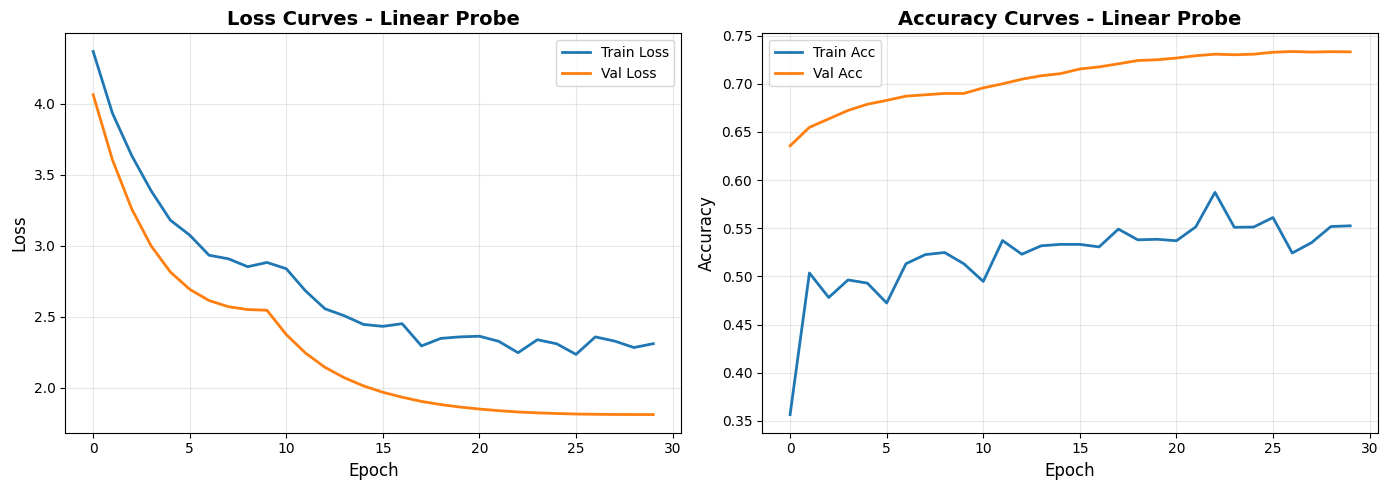


APPROACH 3: Fine-tuning CLIP with Advanced Optimization

Fine-tuning CLIP for 20 epochs...


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.13it/s]


Epoch 1/20 - Train Loss: 3.9623, Train Acc: 0.2098, Val Loss: 2.9112, Val Acc: 0.4578


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.03it/s]


Epoch 2/20 - Train Loss: 3.0123, Train Acc: 0.3536, Val Loss: 2.3115, Val Acc: 0.5944


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.98it/s]


Epoch 3/20 - Train Loss: 2.6746, Train Acc: 0.4366, Val Loss: 2.0770, Val Acc: 0.6550


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


Epoch 4/20 - Train Loss: 2.5497, Train Acc: 0.4786, Val Loss: 1.9683, Val Acc: 0.6812


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s]


Epoch 5/20 - Train Loss: 2.4224, Train Acc: 0.5049, Val Loss: 1.9148, Val Acc: 0.6948


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.99it/s]


Epoch 6/20 - Train Loss: 2.4207, Train Acc: 0.4896, Val Loss: 1.8920, Val Acc: 0.6992


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.95it/s]


Epoch 7/20 - Train Loss: 2.4034, Train Acc: 0.5012, Val Loss: 1.8857, Val Acc: 0.7020


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s]


Epoch 8/20 - Train Loss: 2.3256, Train Acc: 0.5132, Val Loss: 1.8150, Val Acc: 0.7080


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


Epoch 9/20 - Train Loss: 2.2907, Train Acc: 0.5299, Val Loss: 1.7560, Val Acc: 0.7262


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


Epoch 10/20 - Train Loss: 2.3360, Train Acc: 0.4873, Val Loss: 1.7239, Val Acc: 0.7260


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


Epoch 11/20 - Train Loss: 2.2101, Train Acc: 0.5341, Val Loss: 1.6906, Val Acc: 0.7350


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.89it/s]


Epoch 12/20 - Train Loss: 2.2453, Train Acc: 0.5332, Val Loss: 1.6693, Val Acc: 0.7384


Evaluating: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s]


Epoch 13/20 - Train Loss: 2.1885, Train Acc: 0.5430, Val Loss: 1.6551, Val Acc: 0.7406


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


Epoch 14/20 - Train Loss: 2.1644, Train Acc: 0.5575, Val Loss: 1.6396, Val Acc: 0.7428


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


Epoch 15/20 - Train Loss: 2.2609, Train Acc: 0.5305, Val Loss: 1.6323, Val Acc: 0.7456


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


Epoch 16/20 - Train Loss: 2.1292, Train Acc: 0.5930, Val Loss: 1.6238, Val Acc: 0.7496


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


Epoch 17/20 - Train Loss: 2.1281, Train Acc: 0.5650, Val Loss: 1.6179, Val Acc: 0.7466


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.07it/s]


Epoch 18/20 - Train Loss: 2.1019, Train Acc: 0.5890, Val Loss: 1.6136, Val Acc: 0.7516


Evaluating: 100%|██████████| 40/40 [00:10<00:00,  3.66it/s]


Epoch 19/20 - Train Loss: 2.1619, Train Acc: 0.5459, Val Loss: 1.6122, Val Acc: 0.7512


Evaluating: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


Epoch 20/20 - Train Loss: 2.1617, Train Acc: 0.5572, Val Loss: 1.6112, Val Acc: 0.7514


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]



Fine-tuned CLIP Test Accuracy: 74.82%


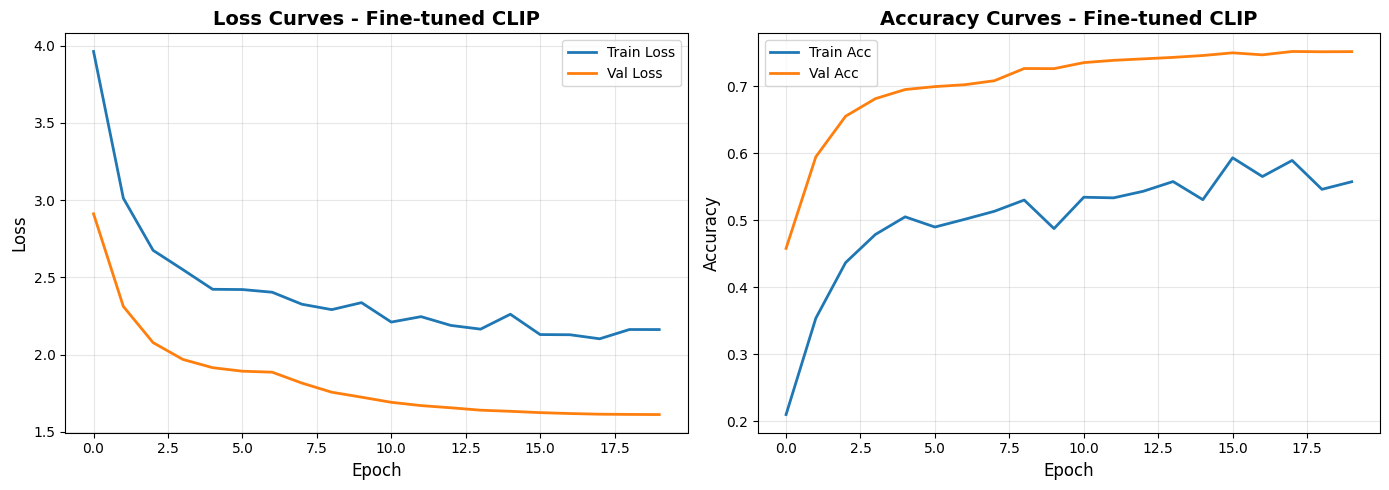


FINAL RESULTS SUMMARY
Zero-shot CLIP:                60.58%
Linear Probe (Best Val):       73.36%
Linear Probe (Test):           72.64%
Fine-tuned CLIP (Best Val):    75.16%
Fine-tuned CLIP (Test):        74.82%

Classification Report - Fine-tuned CLIP (Best Model):
               precision    recall  f1-score   support

        apple      0.918     0.900     0.909       100
aquarium_fish      0.879     0.800     0.838       100
         baby      0.778     0.770     0.774       100
         bear      0.612     0.630     0.621       100
       beaver      0.416     0.470     0.441       100
          bed      0.775     0.690     0.730       100
          bee      0.785     0.840     0.812       100
       beetle      0.838     0.670     0.744       100
      bicycle      0.948     0.910     0.929       100
       bottle      0.948     0.920     0.934       100
         bowl      0.612     0.520     0.562       100
          boy      0.663     0.650     0.657       100
       bridge   

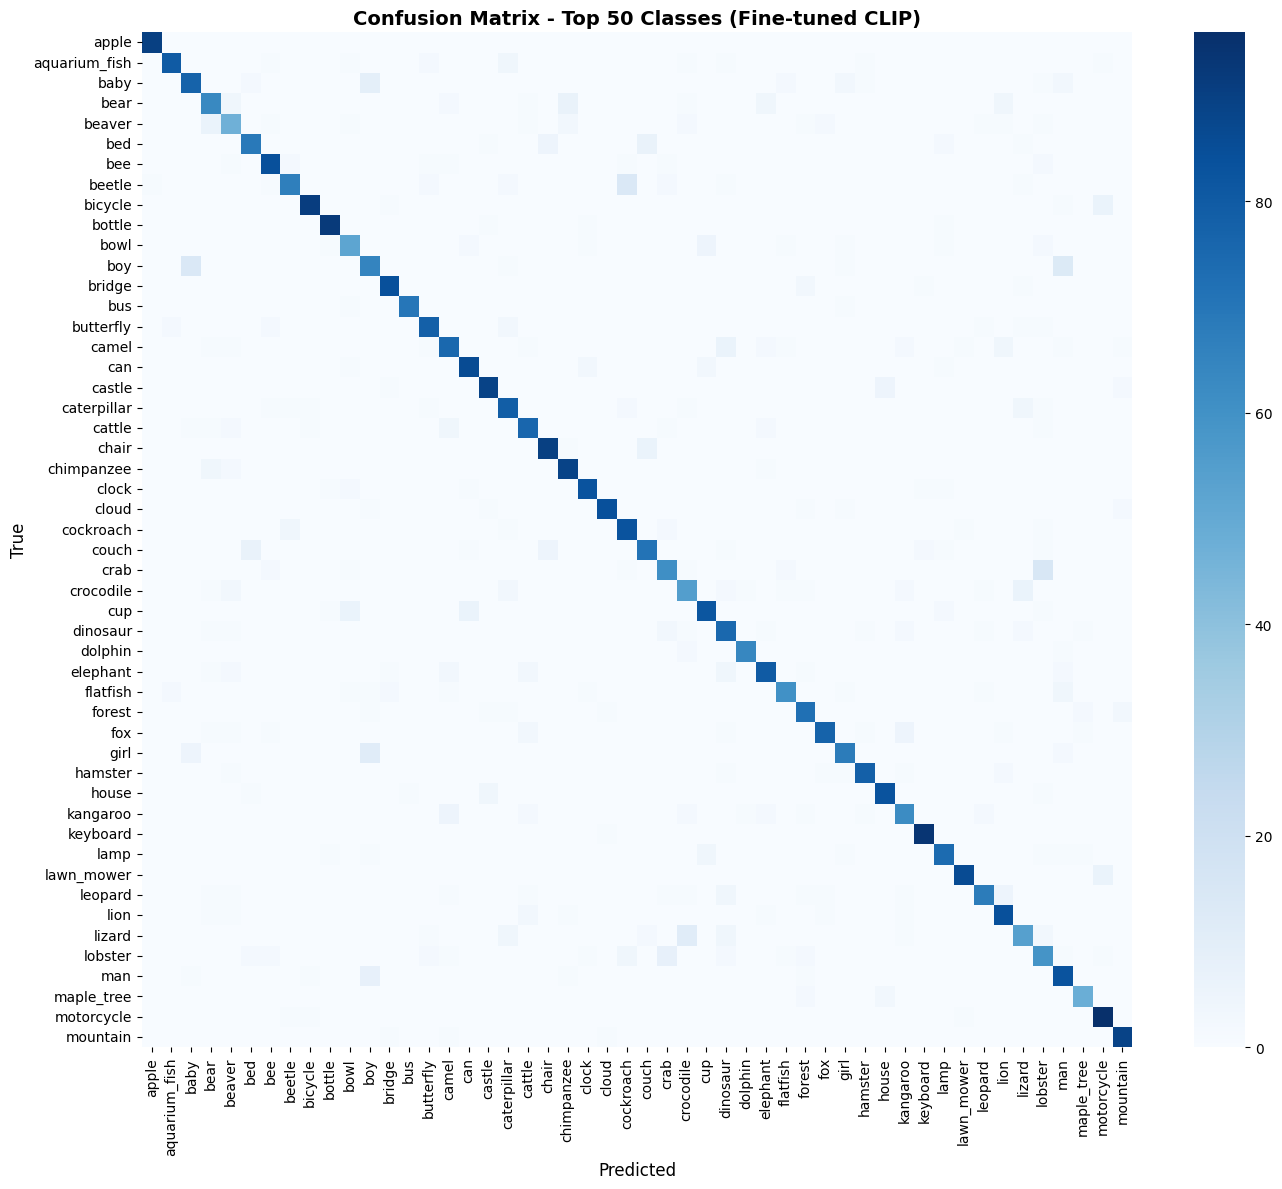


✅ Training complete! Models and visualizations saved.
Best models saved as:
  - clip_linear_probe_best.pth
  - clip_finetuned_best.pth


In [ ]:
# ============================================================
# IMPROVED CIFAR-100 Classification with OpenAI CLIP
# ============================================================
# This script implements advanced techniques to boost CLIP performance:
# 1. Aggressive data augmentation (Mixup, CutMix, RandAugment)
# 2. Advanced optimization (AdamW, CosineAnnealingWarmRestarts)
# 3. Hyperparameter tuning ready
# 4. Better regularization

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import clip



def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)


    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ============================================================
# HYPERPARAMETERS
# ============================================================
CONFIG = {
    'batch_size': 128,
    'num_epochs_linear': 30,  # Increased from 20
    'num_epochs_finetune': 20,  # Increased from 15
    'lr_linear': 0.001,
    'lr_finetune_backbone': 5e-7,  # Lower for stability
    'lr_finetune_head': 5e-4,  # Higher for classifier
    'weight_decay': 0.01,
    'dropout': 0.3,  # Increased from 0.2
    'mixup_alpha': 0.2,  # Mixup parameter
    'cutmix_alpha': 1.0,  # CutMix parameter
    'augmentation_prob': 0.5,  # Probability of applying mixup/cutmix
    'label_smoothing': 0.1,  # Label smoothing for better generalization
}


model_name = "ViT-B/32"
clip_model, preprocess = clip.load(model_name, device=device)
print(f"Loaded CLIP model: {model_name}")



train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                       (0.26862954, 0.26130258, 0.27577711))
])


train_dataset_full = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=val_test_transform)

train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(
    train_dataset_full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


val_dataset.dataset.transform = val_test_transform

class_names = train_dataset_full.classes
num_classes = len(class_names)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                         shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                       shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=False, num_workers=4, pin_memory=True)


print("\n" + "="*60)
print("APPROACH 1: Zero-Shot Classification")
print("="*60)

text_prompts = [f"a photo of a {class_name}" for class_name in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

def zero_shot_predict(model, loader, text_features):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Zero-shot inference"):
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            _, predicted = similarity.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
    return np.array(all_targets), np.array(all_preds)

targets, preds = zero_shot_predict(clip_model, test_loader, text_features)
zero_shot_accuracy = (targets == preds).mean()
print(f"Zero-shot Test Accuracy: {zero_shot_accuracy*100:.2f}%")


print("\n" + "="*60)
print("APPROACH 2: Linear Probe with Advanced Optimization")
print("="*60)

class CLIPLinearProbe(nn.Module):
    def __init__(self, clip_model, num_classes, feature_dim=512, dropout=0.3):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feature_dim, num_classes)
        )
        for param in self.clip_model.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features.float())
        return logits

linear_probe = CLIPLinearProbe(clip_model, num_classes, dropout=CONFIG['dropout']).to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])


optimizer = optim.AdamW(
    linear_probe.classifier.parameters(),
    lr=CONFIG['lr_linear'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

def train_epoch_advanced(model, loader, optimizer, criterion, use_mixup=True, use_cutmix=True):
    """Advanced training loop with Mixup and CutMix"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in tqdm(loader, desc="Training"):
        images, targets = images.to(device), targets.to(device)


        r = np.random.rand()
        if use_mixup and r < CONFIG['augmentation_prob'] / 2:
            images, targets_a, targets_b, lam = mixup_data(images, targets, CONFIG['mixup_alpha'])
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        elif use_cutmix and r < CONFIG['augmentation_prob']:
            images, targets_a, targets_b, lam = cutmix_data(images, targets, CONFIG['cutmix_alpha'])
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    for images, targets in tqdm(loader, desc="Evaluating"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)

num_epochs = CONFIG['num_epochs_linear']
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print(f"\nTraining Linear Probe for {num_epochs} epochs...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_advanced(
        linear_probe, train_loader, optimizer, criterion,
        use_mixup=True, use_cutmix=True
    )
    val_loss, val_acc, _, _ = evaluate(linear_probe, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(linear_probe.state_dict(), 'clip_linear_probe_best.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


linear_probe.load_state_dict(torch.load('clip_linear_probe_best.pth'))
test_loss, test_acc, test_targets, test_preds = evaluate(linear_probe, test_loader, criterion)
print(f"\nLinear Probe Test Accuracy: {test_acc*100:.2f}%")


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves - Linear Probe', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', linewidth=2)
plt.plot(val_accs, label='Val Acc', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves - Linear Probe', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('linear_probe_training_curves.png', dpi=150)
plt.show()


print("\n" + "="*60)
print("APPROACH 3: Fine-tuning CLIP with Advanced Optimization")
print("="*60)

class CLIPFineTune(nn.Module):
    def __init__(self, clip_model, num_classes, feature_dim=512, dropout=0.3):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, images):
        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features.float())
        return logits

finetune_model = CLIPFineTune(clip_model, num_classes, dropout=CONFIG['dropout']).to(device)


optimizer_ft = optim.AdamW([
    {'params': finetune_model.clip_model.parameters(), 'lr': CONFIG['lr_finetune_backbone']},
    {'params': finetune_model.classifier.parameters(), 'lr': CONFIG['lr_finetune_head']}
], weight_decay=CONFIG['weight_decay'])

scheduler_ft = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_ft, T_0=7, T_mult=2, eta_min=1e-7
)

num_epochs_ft = CONFIG['num_epochs_finetune']
train_losses_ft, train_accs_ft = [], []
val_losses_ft, val_accs_ft = [], []
best_val_acc_ft = 0.0

print(f"\nFine-tuning CLIP for {num_epochs_ft} epochs...")
for epoch in range(num_epochs_ft):
    train_loss, train_acc = train_epoch_advanced(
        finetune_model, train_loader, optimizer_ft, criterion,
        use_mixup=True, use_cutmix=True
    )
    val_loss, val_acc, _, _ = evaluate(finetune_model, val_loader, criterion)
    scheduler_ft.step()

    train_losses_ft.append(train_loss)
    train_accs_ft.append(train_acc)
    val_losses_ft.append(val_loss)
    val_accs_ft.append(val_acc)


    if val_acc > best_val_acc_ft:
        best_val_acc_ft = val_acc
        torch.save(finetune_model.state_dict(), 'clip_finetuned_best.pth')

    print(f"Epoch {epoch+1}/{num_epochs_ft} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


finetune_model.load_state_dict(torch.load('clip_finetuned_best.pth'))
ft_test_loss, ft_test_acc, ft_test_targets, ft_test_preds = evaluate(
    finetune_model, test_loader, criterion
)
print(f"\nFine-tuned CLIP Test Accuracy: {ft_test_acc*100:.2f}%")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_ft, label='Train Loss', linewidth=2)
plt.plot(val_losses_ft, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves - Fine-tuned CLIP', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs_ft, label='Train Acc', linewidth=2)
plt.plot(val_accs_ft, label='Val Acc', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves - Fine-tuned CLIP', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('finetuned_training_curves.png', dpi=150)
plt.show()


print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Zero-shot CLIP:                {zero_shot_accuracy*100:.2f}%")
print(f"Linear Probe (Best Val):       {best_val_acc*100:.2f}%")
print(f"Linear Probe (Test):           {test_acc*100:.2f}%")
print(f"Fine-tuned CLIP (Best Val):    {best_val_acc_ft*100:.2f}%")
print(f"Fine-tuned CLIP (Test):        {ft_test_acc*100:.2f}%")
print("="*60)

print("\nClassification Report - Fine-tuned CLIP (Best Model):")
print(classification_report(ft_test_targets, ft_test_preds, target_names=class_names, digits=3))


fig, ax = plt.subplots(figsize=(14, 12))
conf_mat = confusion_matrix(ft_test_targets, ft_test_preds)
sns.heatmap(conf_mat[:50, :50], cmap='Blues', ax=ax, cbar=True,
            xticklabels=class_names[:50], yticklabels=class_names[:50])
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix - Top 50 Classes (Fine-tuned CLIP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\n Training complete! Models and visualizations saved.")
print("Best models saved as:")
print("  - clip_linear_probe_best.pth")
print("  - clip_finetuned_best.pth")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-slthdy5m
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-slthdy5m
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0a349ae6bbc2b08a2eac56349a273aa9d674e04e7fd10f50fa94fae220757c63
  Stored in directory: /tmp/pip-ephem-wheel-cache-q0l2ilxh/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
Using device: cuda


100%|██████████| 169M/169M [00:03<00:00, 48.8MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: 45000, Validation: 5000, Test: 10000

Loading CLIP (ViT-B/32) with LoRA Adapters...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

trainable params: 983,040 || all params: 152,260,353 || trainable%: 0.6456

LoRA Fine-tuning CLIP for 20 epochs...



Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 1/20 - Train Loss: 3.2364, Train Acc: 0.3244, Val Loss: 1.9076, Val Acc: 0.7032


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 2/20 - Train Loss: 1.9871, Train Acc: 0.6320, Val Loss: 1.4230, Val Acc: 0.8054


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


Epoch 3/20 - Train Loss: 1.8465, Train Acc: 0.6500, Val Loss: 1.3177, Val Acc: 0.8344


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


Epoch 4/20 - Train Loss: 1.7222, Train Acc: 0.6973, Val Loss: 1.2555, Val Acc: 0.8458


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 5/20 - Train Loss: 1.6043, Train Acc: 0.6984, Val Loss: 1.2229, Val Acc: 0.8576


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 6/20 - Train Loss: 1.5823, Train Acc: 0.6804, Val Loss: 1.2140, Val Acc: 0.8612


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


Epoch 7/20 - Train Loss: 1.4744, Train Acc: 0.7369, Val Loss: 1.2065, Val Acc: 0.8624


Evaluating: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Epoch 8/20 - Train Loss: 1.5658, Train Acc: 0.7254, Val Loss: 1.2396, Val Acc: 0.8514


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 9/20 - Train Loss: 1.4759, Train Acc: 0.7364, Val Loss: 1.2314, Val Acc: 0.8496


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Epoch 10/20 - Train Loss: 1.5049, Train Acc: 0.7324, Val Loss: 1.2185, Val Acc: 0.8570


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 11/20 - Train Loss: 1.5119, Train Acc: 0.7158, Val Loss: 1.1985, Val Acc: 0.8650


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


Epoch 12/20 - Train Loss: 1.4273, Train Acc: 0.7727, Val Loss: 1.2002, Val Acc: 0.8622


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 13/20 - Train Loss: 1.3469, Train Acc: 0.7551, Val Loss: 1.1981, Val Acc: 0.8652


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Epoch 14/20 - Train Loss: 1.3694, Train Acc: 0.7642, Val Loss: 1.1902, Val Acc: 0.8664


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


Epoch 15/20 - Train Loss: 1.3385, Train Acc: 0.7725, Val Loss: 1.1957, Val Acc: 0.8678


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


Epoch 16/20 - Train Loss: 1.3536, Train Acc: 0.7686, Val Loss: 1.1816, Val Acc: 0.8712


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


Epoch 17/20 - Train Loss: 1.3969, Train Acc: 0.7677, Val Loss: 1.1781, Val Acc: 0.8730


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Epoch 18/20 - Train Loss: 1.2351, Train Acc: 0.7886, Val Loss: 1.1844, Val Acc: 0.8710


Evaluating: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Epoch 19/20 - Train Loss: 1.3215, Train Acc: 0.7710, Val Loss: 1.1832, Val Acc: 0.8714


Evaluating: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


Epoch 20/20 - Train Loss: 1.3334, Train Acc: 0.7779, Val Loss: 1.1817, Val Acc: 0.8712


Evaluating: 100%|██████████| 79/79 [00:29<00:00,  2.70it/s]



LoRA Fine-tuned CLIP Test Accuracy: 86.53%


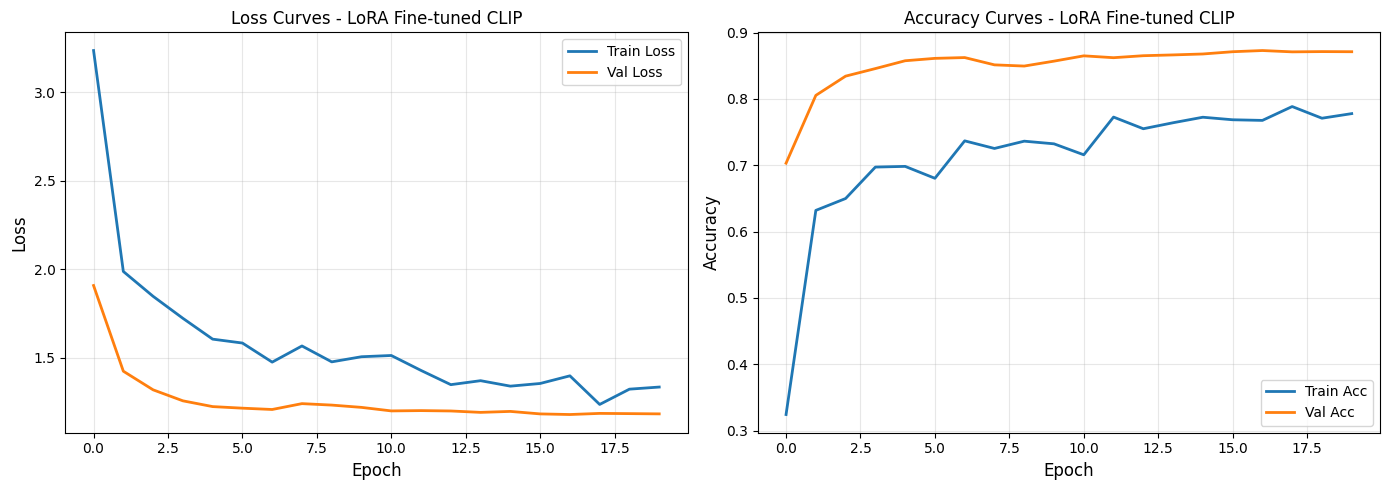


Classification Report - LoRA Fine-tuned CLIP (Best Model):
               precision    recall  f1-score   support

        apple      0.959     0.940     0.949       100
aquarium_fish      0.949     0.940     0.945       100
         baby      0.854     0.820     0.837       100
         bear      0.851     0.800     0.825       100
       beaver      0.615     0.750     0.676       100
          bed      0.898     0.880     0.889       100
          bee      0.895     0.940     0.917       100
       beetle      0.891     0.820     0.854       100
      bicycle      0.949     0.930     0.939       100
       bottle      0.933     0.970     0.951       100
         bowl      0.804     0.740     0.771       100
          boy      0.690     0.800     0.741       100
       bridge      0.920     0.920     0.920       100
          bus      0.874     0.830     0.851       100
    butterfly      0.989     0.900     0.942       100
        camel      0.875     0.910     0.892       100
    

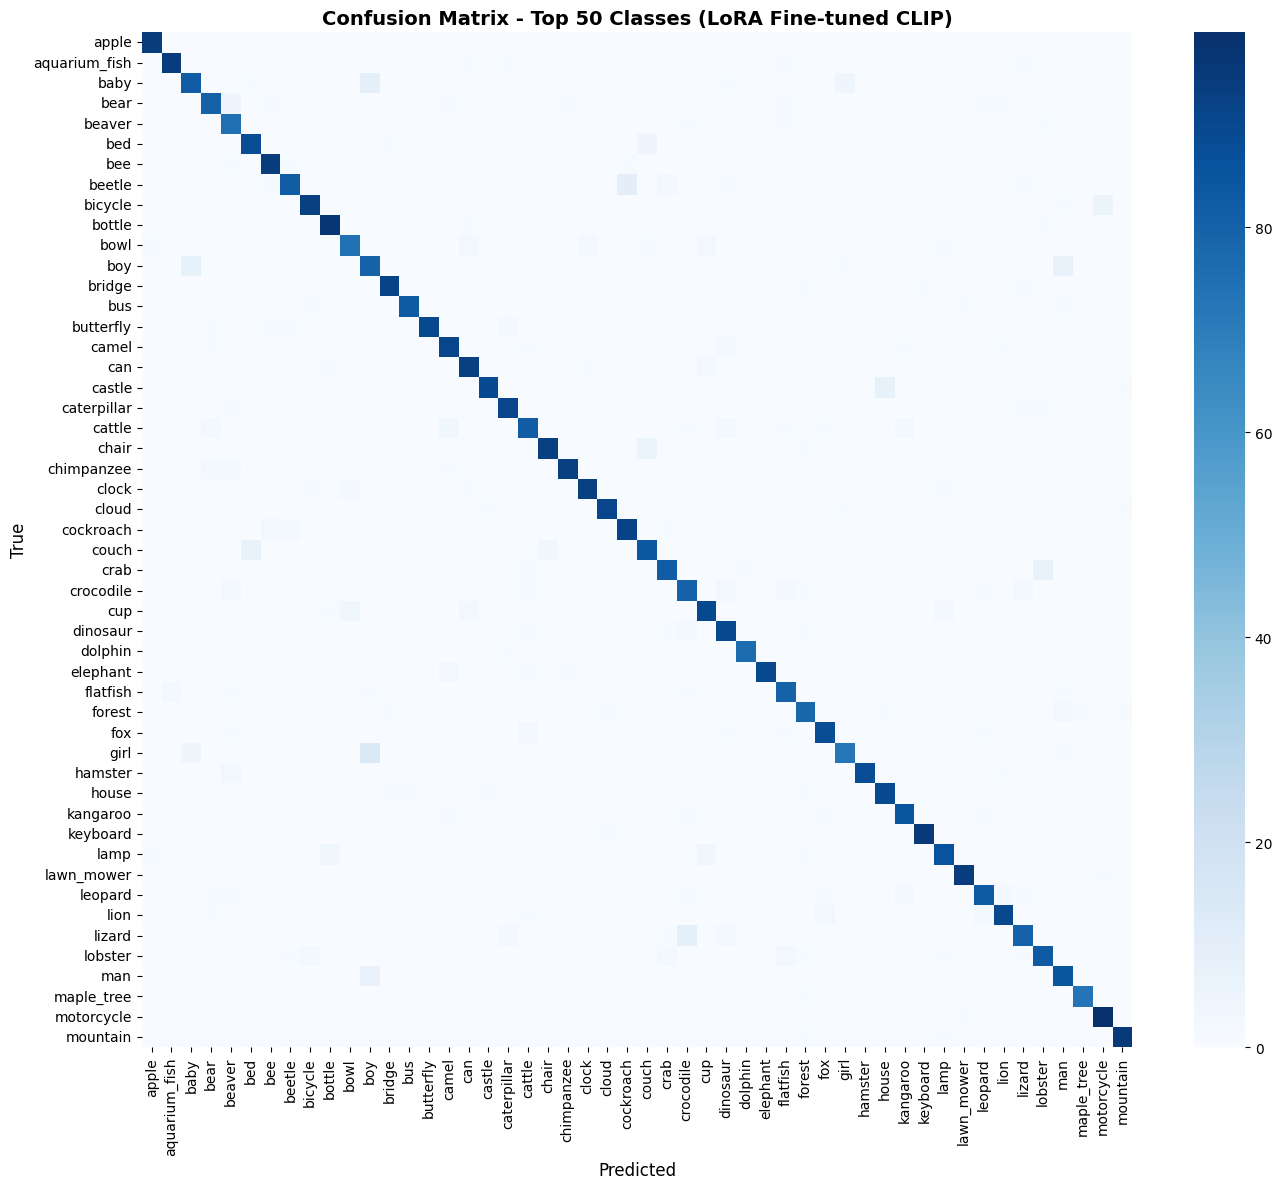


✅ LoRA training complete! Best model saved as 'clip_lora_finetuned_best.pth'


In [ ]:


!pip install -q transformers peft timm
!pip uninstall -y open_clip_torch
!pip install git+https://github.com/openai/CLIP.git


import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

from transformers import CLIPModel, CLIPProcessor
from peft import LoraConfig, get_peft_model

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])
val_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

train_dataset_full = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=val_test_transform)
train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(
    train_dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)
val_dataset.dataset.transform = val_test_transform

class_names = train_dataset_full.classes
num_classes = len(class_names)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def rand_bbox(size, lam):
    W, H = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam


print("\nLoading CLIP (ViT-B/32) with LoRA Adapters...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
lora_config = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.1, target_modules=["q_proj", "v_proj"], bias="none"
)
clip_model = get_peft_model(clip_model, lora_config)
clip_model.print_trainable_parameters()

class CLIPLoRAClassifier(nn.Module):
    def __init__(self, clip_model, num_classes, dropout=0.3):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(512, 512), nn.ReLU(),
            nn.Dropout(dropout * 0.5), nn.Linear(512, num_classes)
        )
    def forward(self, images):
        image_features = self.clip_model.get_image_features(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features.float())
        return logits

model = CLIPLoRAClassifier(clip_model, num_classes, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4, weight_decay=0.01
)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=7, T_mult=2, eta_min=1e-7
)

def train_epoch_advanced(model, loader, optimizer, criterion, use_mixup=True, use_cutmix=True, mixup_alpha=0.2, cutmix_alpha=1.0, aug_prob=0.5):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, targets in tqdm(loader, desc="Training"):
        images, targets = images.to(device), targets.to(device)
        r = np.random.rand()
        if use_mixup and r < aug_prob/2:
            images_, targets_a, targets_b, lam = mixup_data(images, targets, mixup_alpha)
            optimizer.zero_grad()
            outputs = model(images_)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        elif use_cutmix and r < aug_prob:
            images_, targets_a, targets_b, lam = cutmix_data(images, targets, cutmix_alpha)
            optimizer.zero_grad()
            outputs = model(images_)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_targets, all_preds = [], []
    for images, targets in tqdm(loader, desc="Evaluating"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)

num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print(f"\nLoRA Fine-tuning CLIP for {num_epochs} epochs...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_advanced(
        model, train_loader, optimizer, criterion,
        use_mixup=True, use_cutmix=True, mixup_alpha=0.2, cutmix_alpha=1.0, aug_prob=0.5
    )
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'clip_lora_finetuned_best.pth')
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

model.load_state_dict(torch.load('clip_lora_finetuned_best.pth'))
ft_test_loss, ft_test_acc, ft_test_targets, ft_test_preds = evaluate(model, test_loader, criterion)
print(f"\nLoRA Fine-tuned CLIP Test Accuracy: {ft_test_acc*100:.2f}%")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves - LoRA Fine-tuned CLIP')
plt.legend()
plt.grid(alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', linewidth=2)
plt.plot(val_accs, label='Val Acc', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Curves - LoRA Fine-tuned CLIP')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lora_finetuned_training_curves.png', dpi=150)
plt.show()

print("\nClassification Report - LoRA Fine-tuned CLIP (Best Model):")
print(classification_report(ft_test_targets, ft_test_preds, target_names=class_names, digits=3))
fig, ax = plt.subplots(figsize=(14, 12))
conf_mat = confusion_matrix(ft_test_targets, ft_test_preds)
sns.heatmap(conf_mat[:50, :50], cmap='Blues', ax=ax, cbar=True,
            xticklabels=class_names[:50], yticklabels=class_names[:50])
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix - Top 50 Classes (LoRA Fine-tuned CLIP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('lora_confusion_matrix.png', dpi=150)
plt.show()

print("\n LoRA training complete! Best model saved as 'clip_lora_finetuned_best.pth'")
